## Imports

In [1]:
from torchvision.transforms import v2
from tqdm.notebook import trange

# from custom files
from dataset import CompCarsImageFolder, WrapperDataset, ImagesFromTextFile, TwoCropTransform
from models import ResNet, resnet_cfg, SupConResNet
from models import train, validate
from utils import *
from losses import SupConLoss

PYTORCH_MPS_HIGH_WATERMARK_RATIO = 0.0

## Configuration

In [2]:
###### Set root to the image folder of CompCars dataset ######

#TODO: ADAPT TO YOUR FOLDER STRUCTURE

# EDO'S PATHS
root = '/Volumes/EDO/NNDL/CompCars dataset/data/image/'
train_file = '/Volumes/EDO/NNDL/CompCars dataset/data/train_test_split/classification/train.txt'
test_file = '/Volumes/EDO/NNDL/CompCars dataset/data/train_test_split/classification/test.txt'

# DEFAULT PATHS
#root = '../cars_data/data/image/'
#train_file = '../cars_data/data/train_test_split/classification/train.txt'
#test_file = '../cars_data/data/train_test_split/classification/test.txt'

#############################################################

### Hyperparam configuration # TODO: TUNE

resnet_type = 'resnet18'                # 'resnet18', 'resnet34', 'resnet50'    

params = {                              ## Training Params (inspired from original resnet paper: https://arxiv.org/pdf/1512.03385)
    'epoch_num': 50,                    # number of epochs
    'lr': 1e-1,                         # (initial) Learning Rate
    'weight_decay': 1e-4,               # L2 Penalty
    'batch_size': 256,                  # batch size (depends on hardware)
    'momentum': 0.9,

    'hierarchy': 0,                     # Choose 0 for manufacturer classification, 1 for model classification
    'val_split': 10000,                 # (float) Fraction of validation holdout / (int) Absolute number of data points in holdout

    'resnet': resnet_cfg[resnet_type],  # ResNet configuration

    'use_train_test_split': False       # True: use prepared split, False: use total dataset
}

### Device
if torch.cuda.is_available():
    params["device"] = torch.device("cuda")   # option for NVIDIA GPUs
elif torch.backends.mps.is_available():
    params["device"] = torch.device("mps")    # option for Mac M-series chips (GPUs)
else:
    params["device"] = torch.device("cpu")    # default option if none of the above devices are available

print("Device: {}".format(params["device"]))

Device: mps


# Data Pipeline (full data set)

## Read total Dataset

In [3]:
### Load full dataset
# hierarchy=0 -> manufacturer classification; hierarchy=1 -> model classification
total_set = CompCarsImageFolder(root, hierarchy=params['hierarchy'])
print(total_set.classes)
print(len(total_set.classes))

['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '9

## Raw Data Visualization

Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (800, 567)
Image shape: (800, 552)
Image shape: (800, 567)
Image shape: (800, 567)
Image shape: (1024, 718)
Image shape: (908, 626)
Image shape: (800, 567)
Image shape: (800, 552)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (1024, 718)
Image shape: (800, 567)
Image shape: (908, 626)


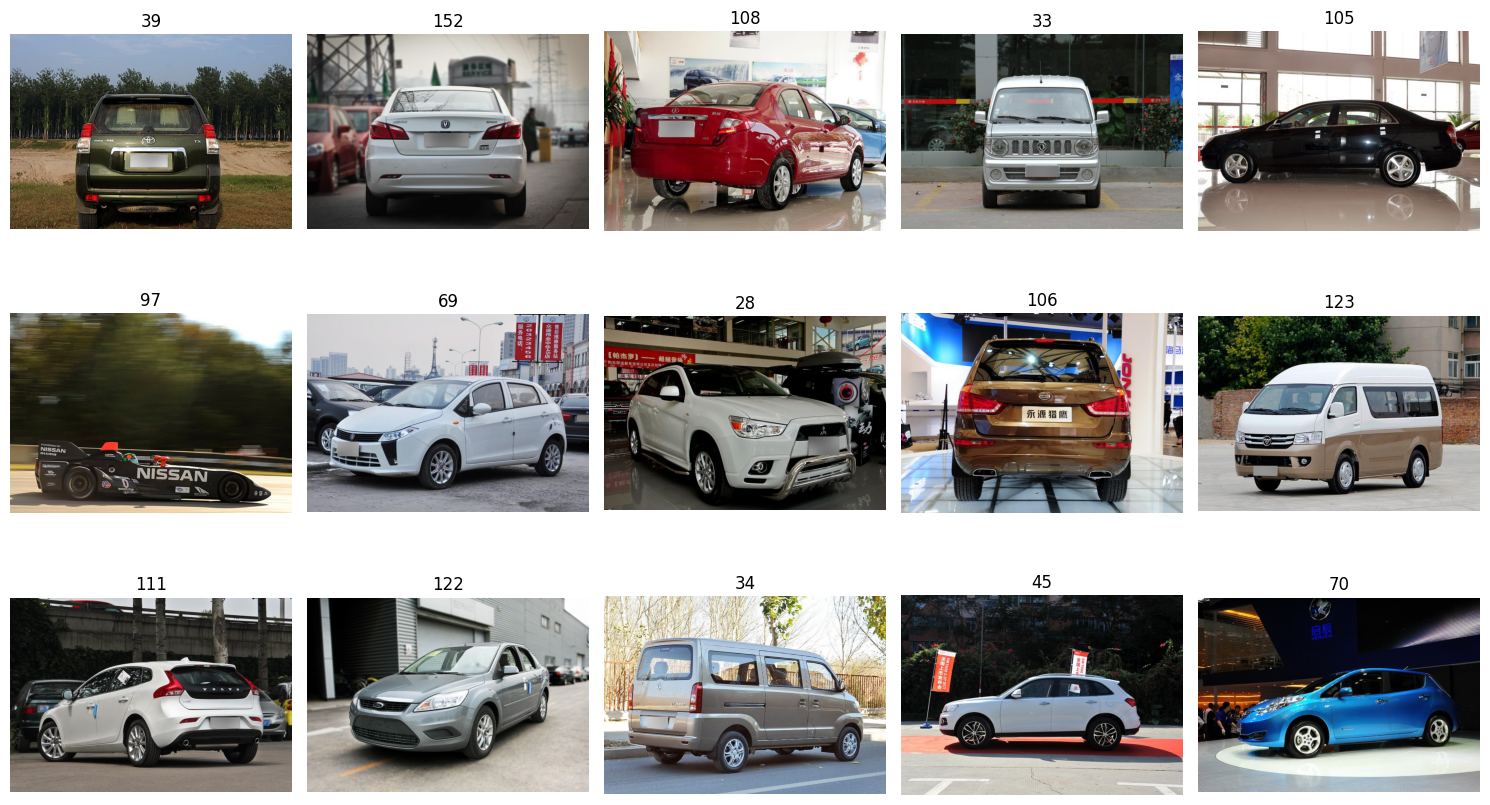

In [4]:
# Visualization of the dataset
label_dict = {y: x for x, y in total_set.class_to_idx.items()}

num_images_to_show = 15
data_idx = np.random.randint(0, high=len(total_set), size=num_images_to_show)
num_cols = 5
num_rows = num_images_to_show // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()
for i in range(num_images_to_show):
    image, label = total_set[data_idx[i]]
    np_img = np.array(image)
    axes[i].imshow(np_img)
    axes[i].set_title(label_dict[label])
    axes[i].axis('off')
    print(f"Image shape: {image.size}")
plt.tight_layout()
plt.show()

## Split in training and validation data

In [5]:
datasets = train_val_dataset(total_set, val_split=params['val_split'])

## Compute normalization statistics

In [6]:
'''
NOTE: This cell takes some time. Could be accelerated by:
    1. Using dataloader (vectorized batches)
    2. Resize images before computing statistics
'''
if params['use_train_test_split']:
    # resulting values from the lines below
    train_mean, train_std = [0.4913, 0.4796, 0.4696], [0.2873, 0.2860, 0.2914]
    val_mean, val_std = [0.4919, 0.4797, 0.4693], [0.2879, 0.2869, 0.2923]

    # Compute mean and std for training dataset
    # train_mean, train_std = compute_mean_std_from_dataset(train_set)
    # print(f"Training dataset mean: {train_mean}")
    # print(f"Training dataset std: {train_std}")

    # Compute mean and std for validation dataset
    # val_mean, val_std = compute_mean_std_from_dataset(test_set)
    # print(f"Validation dataset mean: {val_mean}")
    # print(f"Validation dataset std: {val_std}")

else:
    # default (computed statistic on whole dataset)
    mean, std = [0.483, 0.471, 0.463], [0.297, 0.296, 0.302]

    # Compute mean and std for training dataset
    # train_mean, train_std = compute_mean_std_from_dataset(datasets['train'])
    # print(f"Training dataset mean: {train_mean}")
    # print(f"Training dataset std: {train_std}")
    train_mean, train_std = mean, std

    # Compute mean and std for validation dataset
    # val_mean, val_std = compute_mean_std_from_dataset(datasets['val'])
    # print(f"Validation dataset mean: {val_mean}")
    # print(f"Validation dataset std: {val_std}")
    val_mean, val_std = mean, std

## Transform data - Prepare DataLoaders

In [7]:
# Apply transformation
########################## Transforms ############################
# TODO: Adapt transforms to our data set
# TODO: maybe use v2 transforms: https://pytorch.org/vision/stable/transforms.html

# inspired from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = { # TODO: TUNE
    'train': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.RandomChoice([
            v2.Resize(256),
            v2.Resize(224),
            v2.Resize(320)
        ]),
        v2.RandomHorizontalFlip(),
        v2.RandomCrop(224),
        v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        v2.ToDtype(torch.float16, scale=True),
        v2.Normalize(train_mean, train_std)
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToDtype(torch.float16, scale=True),
        v2.Normalize(val_mean, val_std)
    ])
}
##################################################################

wrapped_datasets = {
    'train': WrapperDataset(datasets['train'], transform=TwoCropTransform(data_transforms['train'])),
    'val': WrapperDataset(datasets['val'], transform=data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(wrapped_datasets['train'], batch_size=params['batch_size'], shuffle=True, num_workers=4),
    'val': DataLoader(wrapped_datasets['val'], batch_size=params['batch_size'], shuffle=False, num_workers=4)
}


print(f"Training dataset size: {len(wrapped_datasets['train'])}")
print(f"Validation dataset size: {len(wrapped_datasets['val'])}")

x, y = next(iter(dataloaders['train']))
print(f"Batch of training images shape: {x[0].shape}")
print(f"Batch of training labels shape: {y.shape}")

x, y = next(iter(dataloaders['val']))
print(f"Batch of validation images shape: {x.shape}")
print(f"Batch of validation labels shape: {y.shape}")

Training dataset size: 126726
Validation dataset size: 10000
Batch of training images shape: torch.Size([256, 3, 224, 224])
Batch of training labels shape: torch.Size([256])
Batch of validation images shape: torch.Size([256, 3, 224, 224])
Batch of validation labels shape: torch.Size([256])


# Training SupCon

## Set-Up

In [8]:
# Set up SupConResNet model
sup_con_resnet = SupConResNet(len(total_set.classes), resnet_type=resnet_type).to(params['device'])

# Loss and Optimizer
criterion = SupConLoss(params["device"], temperature=0.1) # TODO: TUNE
optimizer = torch.optim.SGD( #SGD used in original resnet paper # TODO: TUNE
    sup_con_resnet.parameters(),
    lr=params['lr'],
    weight_decay=params['weight_decay'],
    momentum=params['momentum']
)

# optimizer = torch.optim.Adam(
#     resnet.parameters(), 
#     lr=params['lr'], 
#     weight_decay=params['weight_decay']
# )

# LR scheduler (using Top-1-Accuracy as Validation metric)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, min_lr=1e-4, patience=2, threshold=1e-3) # TODO: TUNE

# Save performance metrics
train_losses, validation_losses, train_acc, validation_acc, train_top5_acc, validation_top5_acc = list(), list(), list(), list(), list(), list()

## Training Loop

To start from checkpoint, set `START_FROM_CHECKPOINT=True`.

In [9]:
CHECKPOINT_PATH = './training_checkpoints/checkpoint.pth'
START_FROM_CHECKPOINT = False   # set to TRUE to start from checkpoint
start_epoch = 0

if START_FROM_CHECKPOINT:
    checkpoint = torch.load(CHECKPOINT_PATH)
    start_epoch = checkpoint['epoch']
    sup_con_resnet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    train_losses = checkpoint['train_losses']

# Just some fancy progress bars # FIXME: inside epoch progress bar not working reliably for me
pbar_epoch = trange(start_epoch, params["epoch_num"], initial=start_epoch, total=params["epoch_num"], desc="Training", position=0, leave=True, unit="epoch", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_inv_fmt}]")
pbar_inside_epoch = trange(0, (len(dataloaders['train'])+len(dataloaders['val'])), desc="Training and validation per epoch", position=1, leave=False, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_inv_fmt}]")

# Stop the training phase in case there is no improvement
# early_stopper = EarlyStopper(patience=10, min_delta=0.1)

for epoch in pbar_epoch:
    pbar_inside_epoch.reset()

    # Training
    train_results = train(dataloaders['train'], sup_con_resnet, epoch, criterion, optimizer, params["device"], pbar=pbar_inside_epoch, sup_con=True)
    train_losses.append(train_results[0])

    # Scheduler
    scheduler.step(train_results[0])   # ReduceLROnPlateau scheduler (reduce LR by 10 when top-1-accuracy does not improve)
    print("\nCurrent Learning Rate: ", round(scheduler.get_last_lr()[0], 4), "\n")

    # Checkpoint
    torch.save({
        'epoch' : epoch + 1,
        'model_state_dict' : sup_con_resnet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict' : scheduler.state_dict(),
        'train_losses': train_losses,
    }, CHECKPOINT_PATH)

    # Comment on the following lines if you don't want to stop early in case of no improvement
    # if early_stopper.early_stop(validation_results[0]):
    #     params['epoch_num'] = epoch
    #     print("\n\nEarly stopping...")
    #     break

pbar_inside_epoch.close()

Training:   0%|          | 0/50 [00:00<?, ?s/epoch]

Training and validation per epoch:   0%|          | 0/536 [00:00<?, ?s/it]

Entering here


RuntimeError: User specified an unsupported autocast device_type 'mps'

# Training Linear Classifier

## Set-Up